In [1]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.manifold import TSNE

In [5]:
#read data
df = pd.read_csv('/content/gdrive/MyDrive/CSE8803_Team2/Classification/Confusion/EEG_data.csv')

In [12]:
# Display the first few rows and general information of the dataset
eeg_data_info = df.info()
eeg_data_head = df.head()

eeg_data_info, eeg_data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB


(None,
    SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
 0        0.0      0.0       56.0       43.0  278.0   301963.0   90612.0   
 1        0.0      0.0       40.0       35.0  -50.0    73787.0   28083.0   
 2        0.0      0.0       47.0       48.0  101.0   758353.0  383745.0   
 3        0.0      0.0       47.0       57.0   -5.0  2012240.0  129350.0   
 4        0.0      0.0       44.0       53.0   -8.0  1005145.0  354328.0   
 
      Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  predefinedlabel  \
 0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0              0.0   
 1    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0              0.0   
 2  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0              0.0   
 3   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0              0.0   
 4   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0              0.0   
 
    user-definedlabeln  
 0                 0.0  
 1       

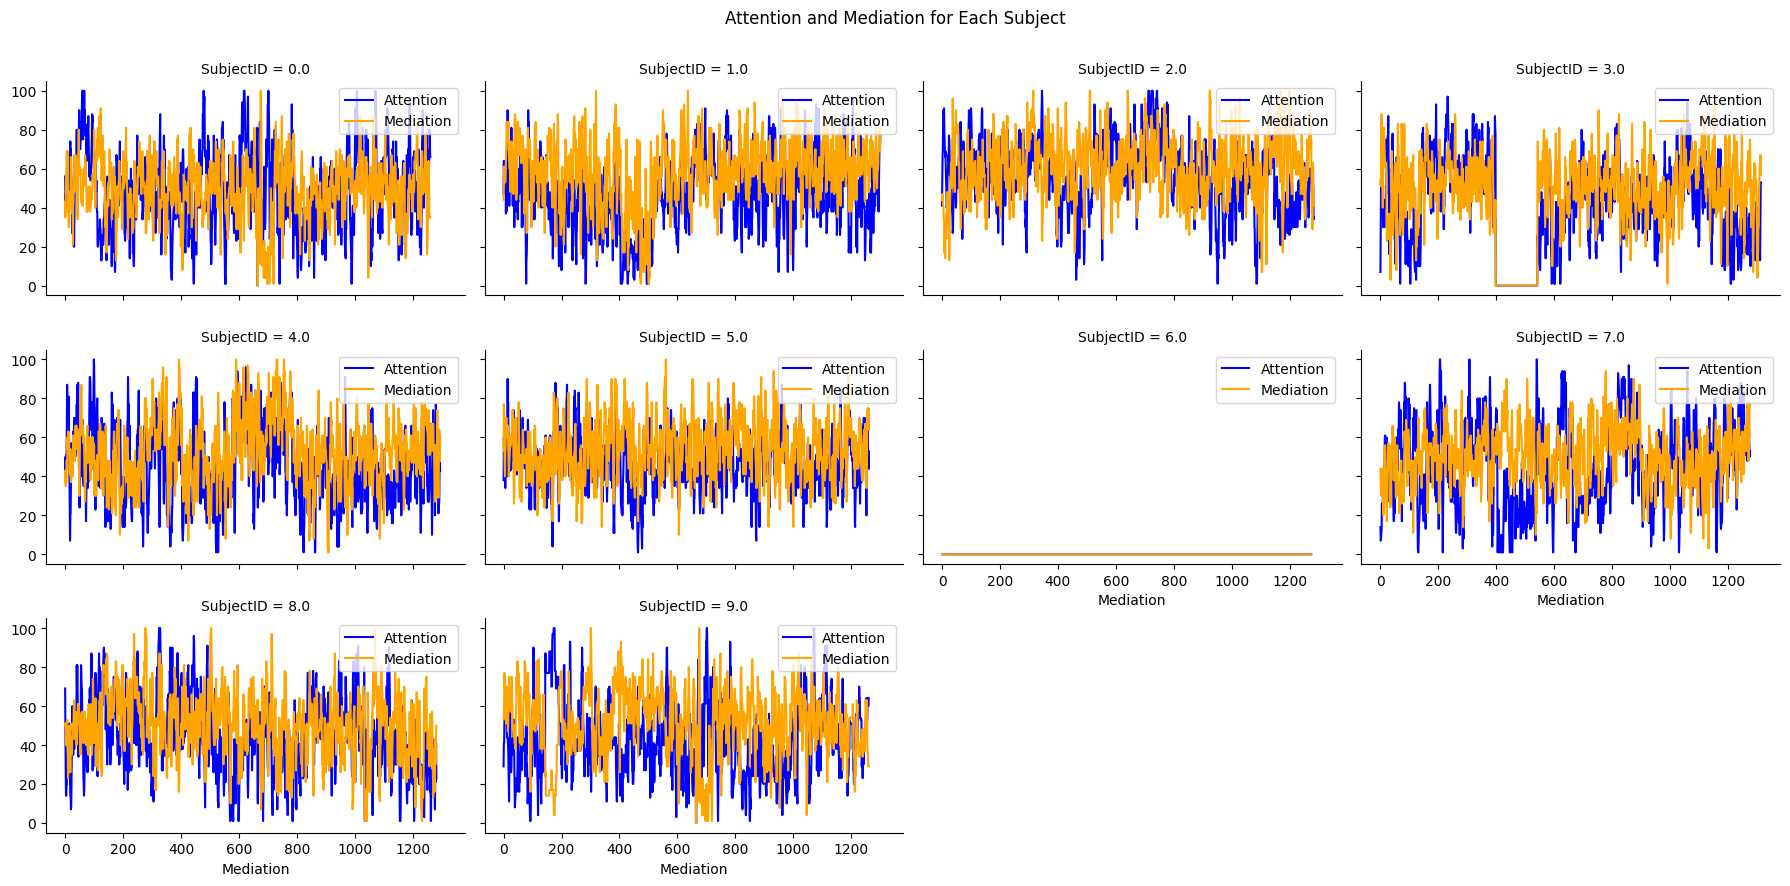

In [10]:
# Time-series plot for Attention and Mediation
# Set the size and layout of the grid (adjust according to number of subjects)
g = sns.FacetGrid(df, col='SubjectID', col_wrap=4, height=3, aspect=1.5)

# Plot Attention and Mediation for each subject
g.map(plt.plot, 'Attention', color='blue', label='Attention')
g.map(plt.plot, 'Mediation', color='orange', label='Mediation')

# Add legend to each subplot
for ax in g.axes.flat:
    ax.legend(['Attention', 'Mediation'], loc='upper right')

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Attention and Mediation for Each Subject')
plt.show()


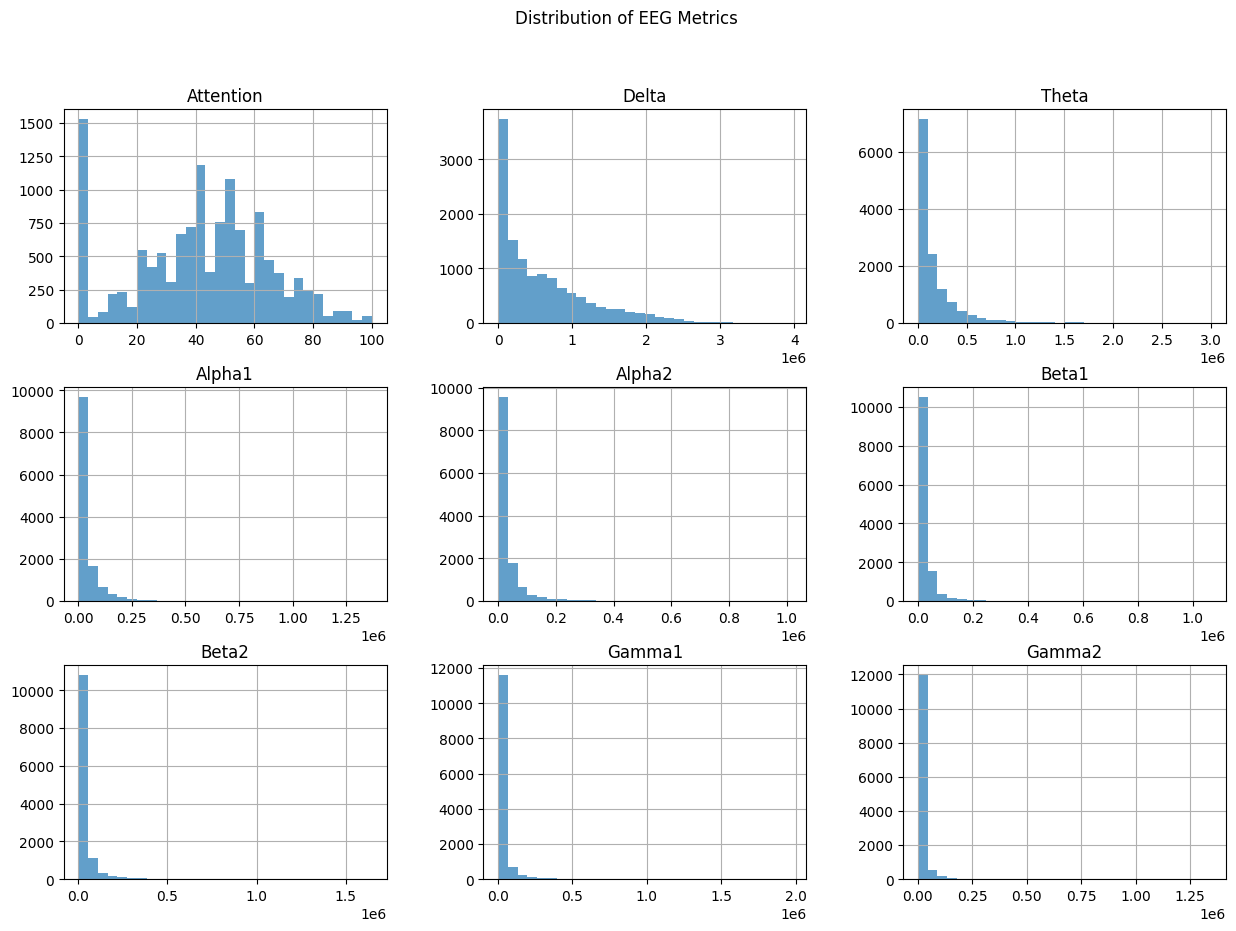

In [11]:
df[['Attention', 'Delta', 'Theta', 'Alpha1', 'Alpha2','Beta1','Beta2','Gamma1','Gamma2']].hist(bins=30, figsize=(15, 10), alpha=0.7)
plt.suptitle('Distribution of EEG Metrics')
plt.show()


In [14]:
# Dropping SubjectID and VideoID for regression
X = df.drop(['SubjectID', 'VideoID', 'predefinedlabel', 'user-definedlabeln'], axis=1)
y = df['user-definedlabeln']

# Splitting the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the feature variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize regression models
models = {
    "Linear Regression": LinearRegression()
}

# Function to train and evaluate models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {"MSE": mse, "R^2": r2}
    return results

# Evaluate the models
model_results = evaluate_models(models, X_train_scaled, X_test_scaled, y_train, y_test)
model_results


{'Linear Regression': {'MSE': 0.23954018658781287, 'R^2': 0.04168038395978102}}

In [15]:
# Preprocessing: Drop unnecessary columns (SubjectID, VideoID)
X = df.drop(['SubjectID', 'VideoID', 'predefinedlabel', 'user-definedlabeln'], axis=1)
y = df['user-definedlabeln']  # Target: continuous confusion level

# Fill missing values
X.fillna(X.mean(), inplace=True)

# Step 1: Feature Selection using RFECV
def perform_feature_selection(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Recursive Feature Elimination with Cross Validation (RFECV)
    linear_reg = LinearRegression()
    rfecv = RFECV(estimator=linear_reg, step=1, cv=5, scoring='neg_mean_squared_error')
    rfecv.fit(X_scaled, y)

    # Select features that are kept
    X_selected = X.loc[:, rfecv.support_]

    print(f"Optimal number of features: {rfecv.n_features_}")
    return X_selected

X_selected = perform_feature_selection(X, y)



Optimal number of features: 9


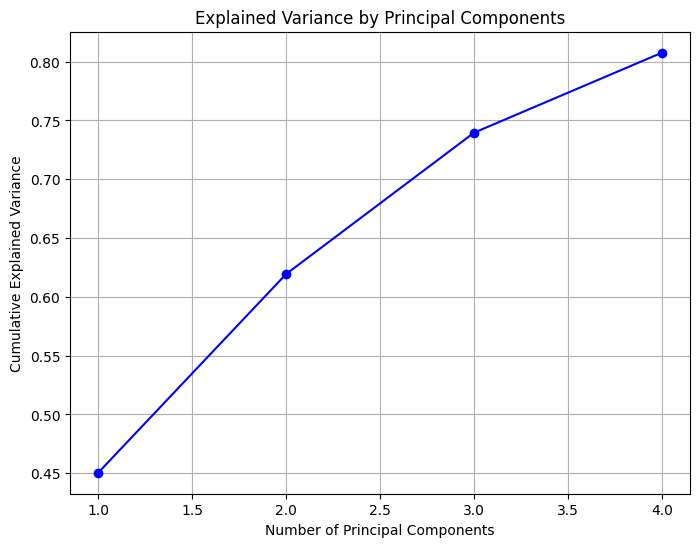

In [16]:
# Step 2: Dimensionality Reduction using PCA
def perform_pca(X, variance_threshold=0.8):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=0.8)  # Keep 80% of the variance
    X_pca = pca.fit_transform(X_scaled)

    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', color='b')
    plt.title('Explained Variance by Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    return X_pca

X_pca = perform_pca(X_selected)



In [ ]:
# Step 3: Visualization with t-SNE




Mean Squared Error: 0.240
R^2 Score: 0.041


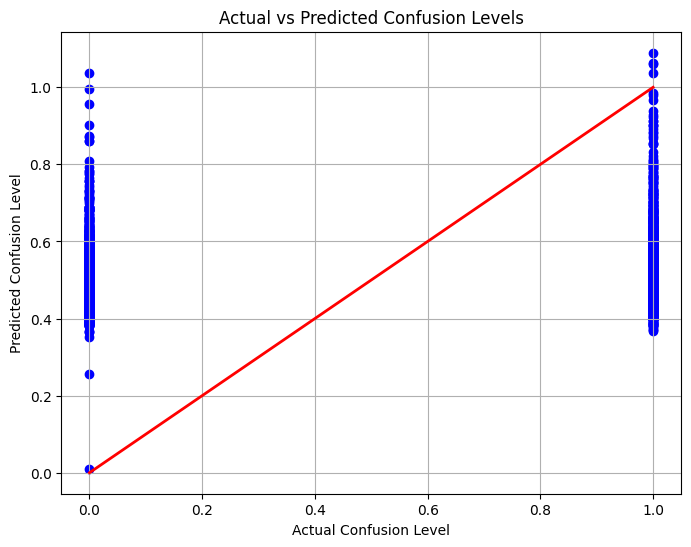

In [18]:
# Step 4: Linear Regression and Model Evaluation
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Predictions
y_pred = linear_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Plot actual vs predicted confusion levels
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('Actual vs Predicted Confusion Levels')
plt.xlabel('Actual Confusion Level')
plt.ylabel('Predicted Confusion Level')
plt.grid(True)
plt.show()